# Target Matching Retired Plants

To match a new plant into one of our existing groups, we simulate a series of **random walks** across the network of already-retired plants.  

- At each step, the plant moves to a neighboring node with probability proportional to feature similarity.  
- Occasionally, if no local options are suitable, the walk **jumps** to the globally best match with 25% probability.  
- After many walks, the plant is assigned to the group it most frequently landed in.  

### Random Walk Algorithm

```mermaid
%%{init: { "theme": "forest" }}%%
stateDiagram-v2
    direction TB
    [*] --> Init: Start random walk
    Init --> GetNeighbors: Pick node v₀
    GetNeighbors --> CalcProbs: Calculate distances & probabilities
    CalcProbs --> CheckJump: Evaluate jump condition
    CheckJump --> Jump: Max distance > threshold (25% chance)
    CheckJump --> Sample: Stay local
    Jump --> CheckSteps
    Sample --> CheckSteps
    CheckSteps --> GetNeighbors: Continue (t < 3000)
    CheckSteps --> Record: Done, record node
    Record --> CheckWalks
    CheckWalks --> Init: Next walk (n < 200)
    CheckWalks --> [*]: Complete
```

**Key idea:** Walk randomly through the graph, favoring nodes similar to the target. Occasionally jump to escape local regions.

**Parameters:** 200 walks × 3000 steps each


## ***Support for MCMC random walks coming to `Thema` soon!***


In [1]:
# Todo: replace with pip install retire 
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import networkx as nx
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

from retire.data import generate_target_matching_data, load_graph, USED_COLUMNS

In [2]:
coal_combined = generate_target_matching_data()
coal_combined_copy = coal_combined[USED_COLUMNS].drop(columns=["Plant Name"]).copy()

<div class="alert alert-block alert-info"> 
<b>NOTE:</b> Target matching relies on advanced topological and geometric deep learning algorithms. These are included in dev dependencies since setup complexity makes them unnecessary for basic graph construction workflows.
</div>

#### Package Manager

We use **[uv](https://docs.astral.sh/uv/)** for dependency management. Written in Rust, it's significantly faster than conda or poetry.

#### Installation
   
   From the repository root, first sync up the environment:
   
   ```bash
   uv sync
   ```
   
   Then install development dependencies including target matching libraries:
   
   ```bash
   uv sync --extra dev
   ```

   This installs all project dependencies, including development tools and the target matching libraries: [Benson](https://github.com/Krv-Analytics/Benson) and [Dect](https://github.com/aidos-lab/dect).

#### Development Workflow

- **Install new packages**: `uv add <package-name>`
- **Update dependencies**: `uv sync`
- **Run tests**: `uv run pytest`

In [3]:
from benson.transformers import PhilTransformer as Phil

Raw Dataset Summary:
```
Rows with any missing: 251/252
Columns with any missing: 40/50
```

## Phil: Progressive High-Dimensional Imputation Lab 🧩

**Phil** is an advanced data imputation framework that rigorously repairs datasets for pipeline use. Like our grid-search in **Thema**, Phil explores multiple representations of a dataset with missing values and selects the most representative one. Specifically, `PhilTransformer` is needed to impute missing values systematically, preserving topological and structural relationships for reliable target matching.

This is especially useful for **target matching retired plants**, where data is often sparse. Phil leverages **[DECT](https://github.com/aidos-lab/dect)** to compare dataset representations and ensure structural patterns are preserved.  

Phil is available via Krv Analytic's **[Benson](https://github.com/Krv-Analytics/Benson)** package and integrates seamlessly into machine learning workflows.


> may take a couple minutes to run `fit_transform()`...

In [ ]:
phil = Phil(random_state=42)
filled_data = phil.fit_transform(coal_combined_copy)

In [6]:
graph = load_graph()
data = filled_data.copy()

These utility functions make it easier to work with the `graph` and the associated `data`:

- `df_from_node(node_id)`:  
  Returns a subset of the DataFrame containing all coal plants that are part of the specified graph node. It uses the node's `membership` attribute to look up the relevant indices.

- `node_average(node_id)`:  
  Computes the column-wise average of all coal plants in the specified node, returning it as a one-row DataFrame.


In [7]:
def df_from_node(node_id: str, graph=graph) -> pd.DataFrame:
    t = graph.nodes[node_id]['membership']
    return data.iloc[t]

def node_average(node_id: str) -> pd.DataFrame:
    return df_from_node(node_id).mean().to_frame().T

In [8]:
node_features = {}
for node in graph.nodes:
    node_features[node] = node_average(node)

In [9]:
cc = list(nx.connected_components(graph))

component_features = {}
for id, component in enumerate(cc):
    comp_average = pd.DataFrame()
    for node in component:
        temp = df_from_node(node)
        comp_average = pd.concat([comp_average, temp])
    comp_average = comp_average.mean().to_frame().T
    
    component_features[id] = comp_average


<div class="alert alert-block alert-info">
<b>Step 3:</b> Transition Probabilities & Random Walk Sampling
</div>

We now define how to turn feature‐based distances into move probabilities, then perform an MCMC‐style random walk over the graph:

1. **`get_transition_probabilities(neighbor_dists, exp_scale=None)`**  
   - Converts an array of distances to unnormalized weights.  
   - If `exp_scale` is set, applies exponential decay:  
     ```python
     weights = exp(-dist * exp_scale)
     ```  
     Larger `exp_scale` ⇒ stronger bias toward closer neighbors.  
   - Normalizes to sum to 1; if all weights are zero, returns a uniform distribution.

2. **`random_walk(G, target, n_samples=1000, m_steps=1000, metric="euclidean")`**  
   - **Input**:  
     - `G`: NetworkX graph.  
     - `target`: 1×D feature vector (e.g. `data.iloc[i]`).  
     - `n_samples`: number of final samples to collect.  
     - `m_steps`: number of hops per sample.  
   - **Procedure**:  
     1. Precompute Euclidean distances from `target` to each node’s features (`node_distances`) and to each group’s features (`group_distances`).  
     2. For each of the `n_samples`:  
        - Pick a random start node.  
        - Repeat `m_steps` times:  
          - Gather neighbors (including self).  
          - Compute transition probs via `get_transition_probabilities(...)`.  
          - Move to a neighbor by sampling with those probabilities.  
          - If all local moves look poor (distance > average group distance) and with ¼ chance, “jump” to the globally best match instead.  
        - Append the final node to `samples`.  
   - **Output**: List of sampled node IDs, reflecting both graph connectivity and feature similarity.


In [ ]:
def get_transition_probabilities(neighbor_dists, exp_scale=None):
    """
    Compute transition probabilities from distances to neighbors.
    
    Parameters:
        neighbor_dists (np.array): Array of distances to neighbors.
        exp_scale (float or None): If provided, applies exponential scaling to probabilities as:
                                   exp(-dist * exp_scale). Higher values = sharper preference for close nodes.
    Returns:
        np.array: Transition probabilities.
    """
    if exp_scale is not None:
        scaled = np.exp(-neighbor_dists * exp_scale)
    else:
        scaled = neighbor_dists.copy()
    
    if scaled.sum() == 0:
        return np.ones_like(scaled) / len(scaled)
    else:
        return scaled / scaled.sum()


def random_walk(G, target=pd.Series, n_samples=1000, m_steps=1000, metric="euclidean"):
    """
    A MCMC inspired method for obtaining a collection of node locations from a
    distribution considering both graph structure and feature differences.
    

    ## --> get `target` from an iloc with single index i.e. `data.iloc[0]`
    """
    target = target.values.reshape(1, -1)

    node_distances = {}
    for key, feature_df in node_features.items():
        distances = cdist(target, feature_df.values, metric='euclidean')
        node_distances[key] = distances[0][0]

    group_distances = {}
    for key, feature_df in component_features.items():
        distances = cdist(target, feature_df.values, metric='euclidean')
        group_distances[key] = distances[0][0]



    samples = []
    for _ in range(n_samples):
        counter = 0
        current_node = np.random.choice(list(G.nodes))
        for __ in range(m_steps):
            # choose a neighbor (including self loops) based on feature distances
            neighbors = list(G.neighbors(current_node)) + [current_node]
            neighbor_dists = np.array([node_distances[n] for n in neighbors if n in node_distances])

            t_probabilities = get_transition_probabilities(neighbor_dists, exp_scale=2)

            # Now choose based on probabilities
            valid_neighbors = [n for n in neighbors if n in node_distances]
            current_node = np.random.choice(valid_neighbors, p=t_probabilities)

# ╭─────────────────────────────────────────────────────────────────────────────────────────────────────╮
# │                                                                                                     │
# │    @team! maybe function-ize this so people can target-match using both methods? We wrote em...      |
# │                                                                                                     │
# ╰─────────────────────────────────────────────────────────────────────────────────────────────────────╯

            ## --> JUMPING SHIP
            # if no good local choices, jump to best matched node instead of random [VERSION USED IN THE PAPER]
            if (
                max(neighbor_dists)
                > np.average(list(group_distances.values()))  # could take Nth quantile here.
                and np.random.rand() < 1 / 4
            ):
                counter += 1
                # jump to best-matching node (i.e., smallest distance)
                best_node = min(node_distances, key=node_distances.get)
                current_node = best_node

            ## --> CODE TO MATCH INTO A RANDOM NODE IF WE ARE JUMPING SHIP [BETTER ALGORITHM]
            # if no good local choices, jump somewhere else with prob 1/4
            # if (
            #     max(neighbor_dists)
            #     > np.average(list(group_distances.values()))  # could take Nth quantile here.
            #     and np.random.rand() < 1 / 4
            # ):
            #     counter+=1
            #     current_node = np.random.choice(list(G.nodes))
        # print(f"Jumped Ship {counter} times")


        samples.append(current_node)
    return samples

<div class="alert alert-block alert-info">
<b>Visualize a Single Random Walk Instance:</b>
The red nodes are scaled according to how many times each node was visited during the random walks.
</div>

We illustrate the workflow using a single plant example.  

`data` is the processed (Phil-imputed) dataset, while `coal_combined` is the raw, human-readable version.  

```python
target=data.iloc[214]
```

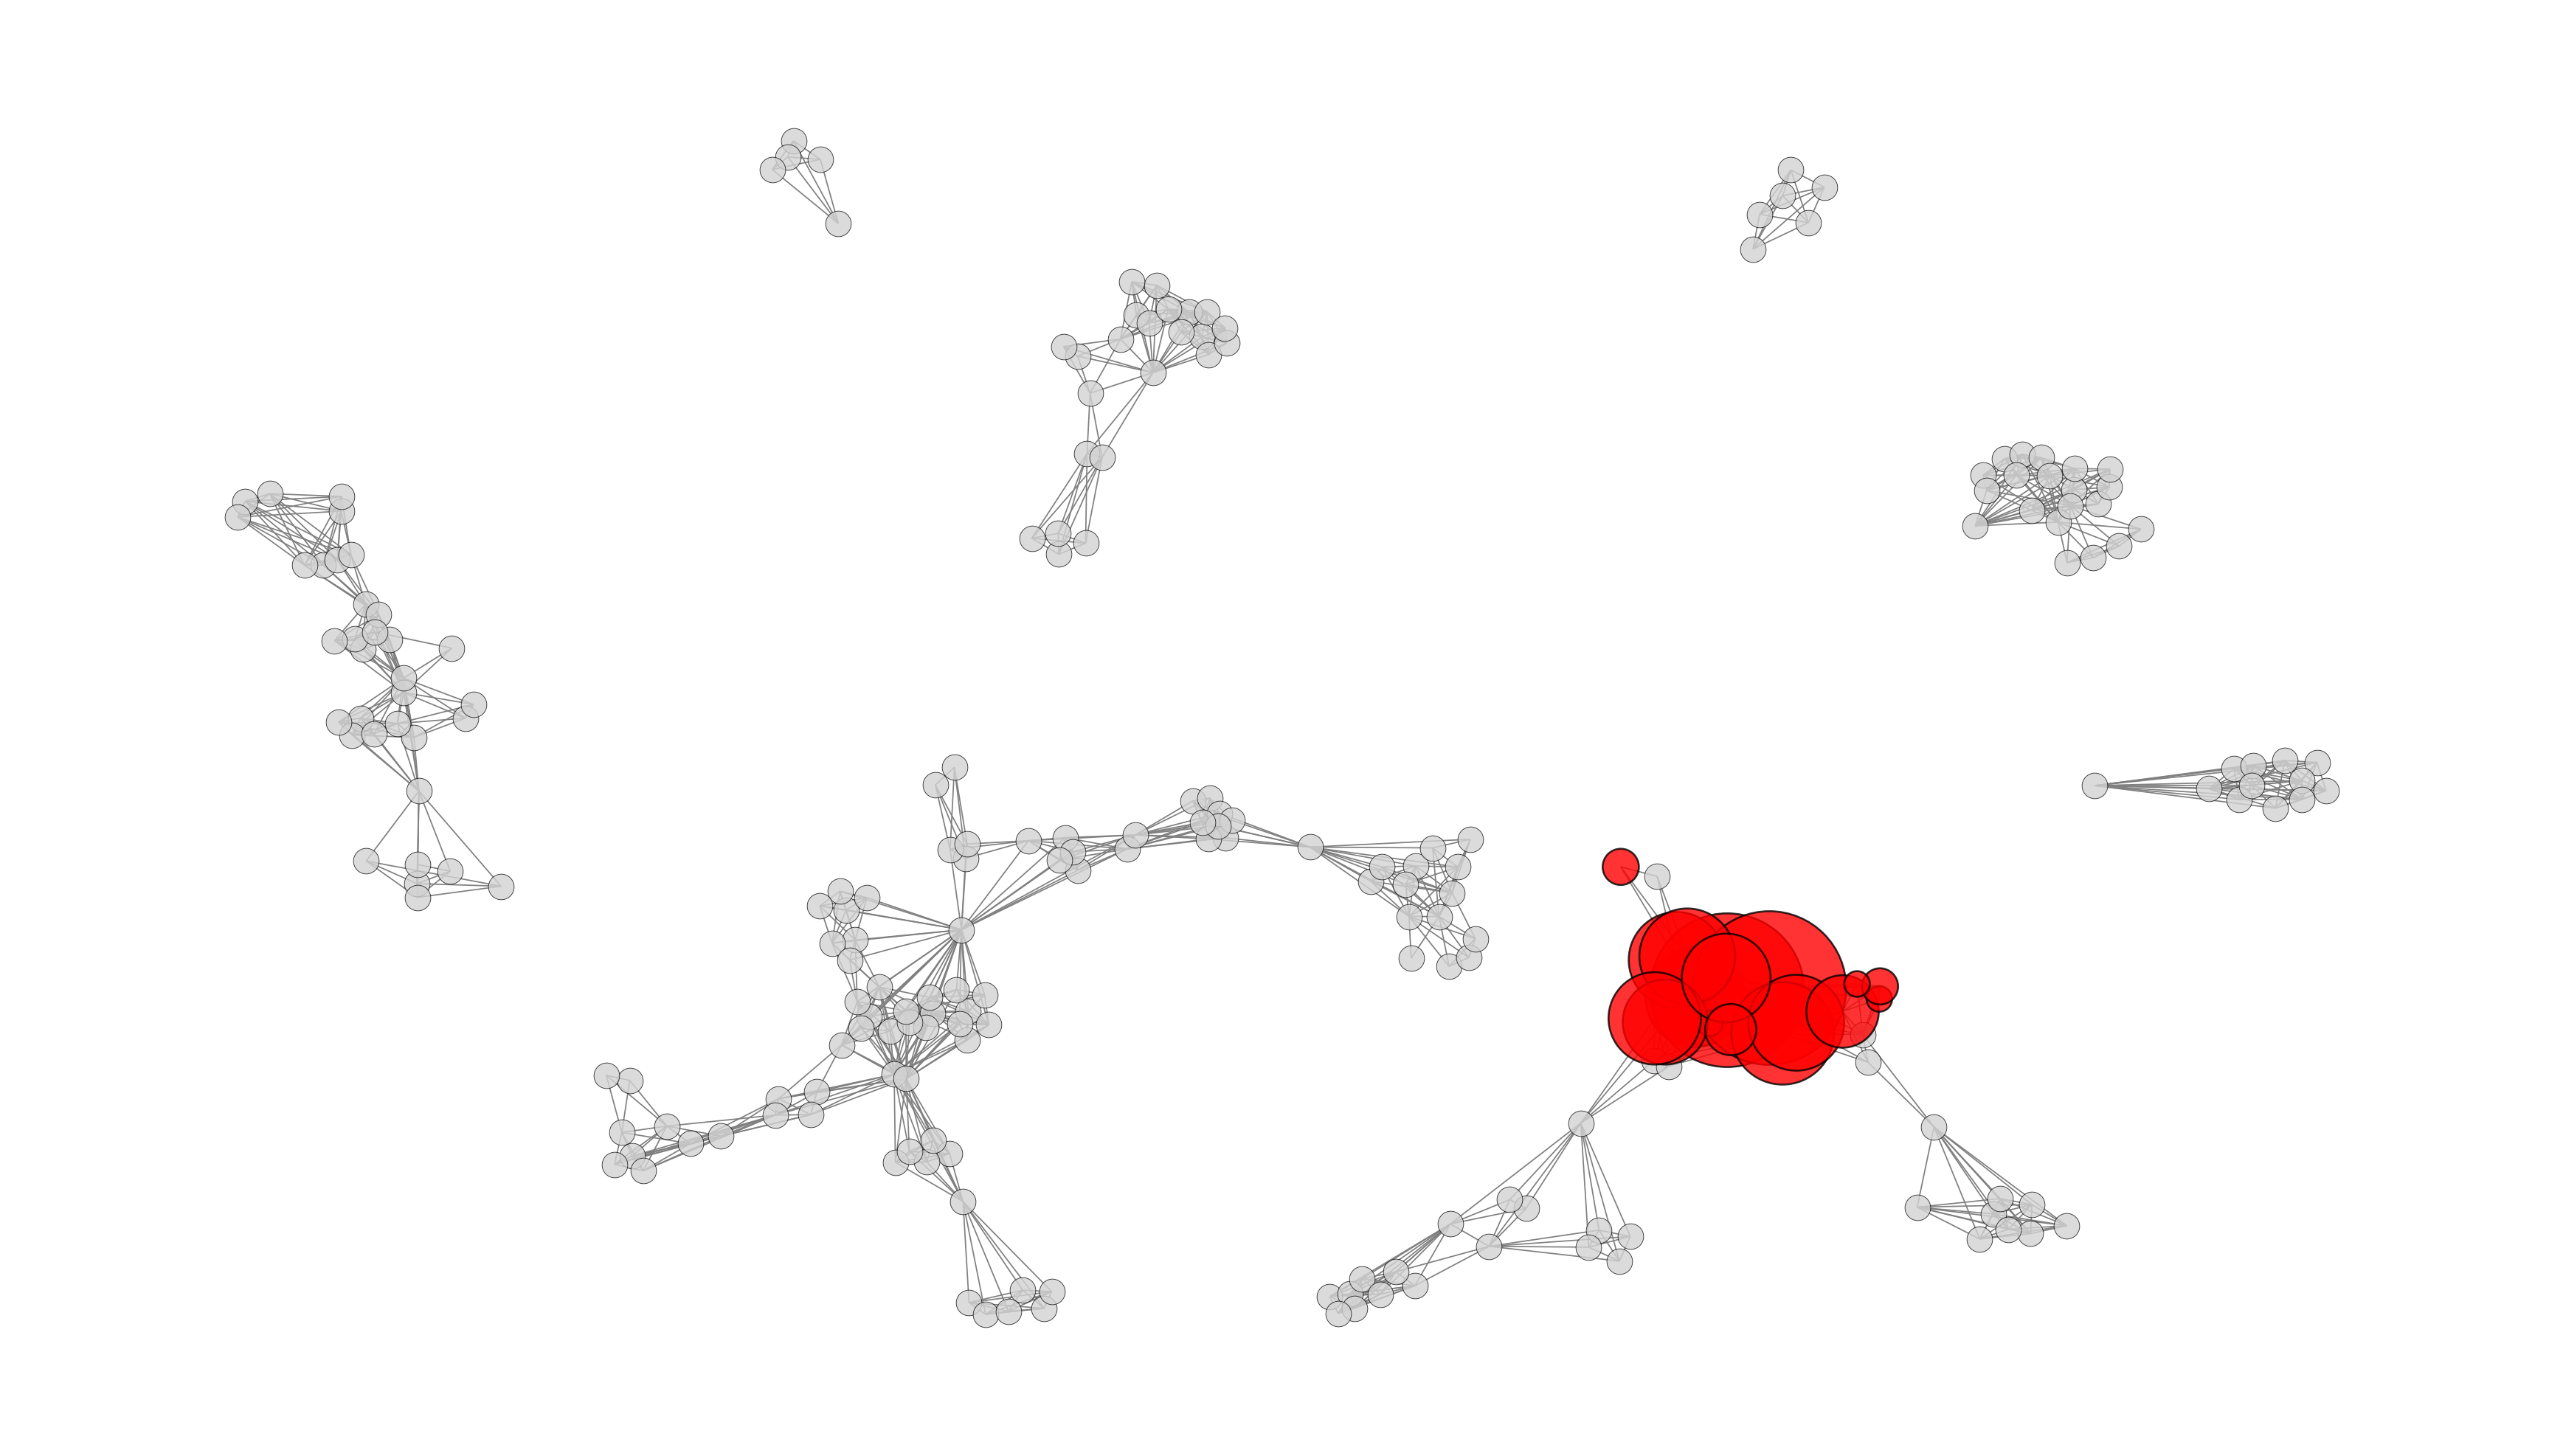

In [ ]:
# Get the connected component index of a node
def get_component_number(G, node_id):
    for i, comp in enumerate(nx.connected_components(G)):
        if node_id in comp:
            return i
    return None

# Highlight specific nodes in a graph
def highlight_nodes(G, target_nodes, pos=None,
                    base_node_size=100, default_color='lightgray', highlight_color='red',
                    edge_color='gray', dpi=250, node_alpha=0.8):
    if pos is None:
        pos = nx.spring_layout(G, seed=12, k=0.09)

    target_counts = Counter(target_nodes)
    plt.figure(figsize=(14, 8), dpi=dpi)
    nx.draw_networkx_edges(G, pos, edge_color=edge_color, width=0.5)

    # Draw non-target nodes
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=[n for n in G.nodes if n not in target_counts],
        node_color=default_color,
        edgecolors='black',
        linewidths=0.25,
        node_size=base_node_size,
        alpha=node_alpha
    )

    # Draw highlighted nodes, scaled by count
    highlights = [(n, base_node_size * c) for n, c in target_counts.items() if n in G]
    if highlights:
        nodes, sizes = zip(*highlights)
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=nodes,
            node_color=highlight_color,
            edgecolors='black',
            linewidths=0.75,
            node_size=sizes,
            alpha=node_alpha
        )

    plt.axis('off')
    plt.tight_layout()
    plt.show()

walk_out = random_walk(graph, target=data.iloc[214], n_samples=200, m_steps=3000)
highlight_nodes(graph, walk_out)


In [12]:
from collections import defaultdict
walk_out

components = list(nx.connected_components(graph))
node_to_component = {}
for idx, comp in enumerate(components):
    for node in comp:
        node_to_component[node] = idx

component_counts = defaultdict(int)
for node in walk_out:
    comp_id = node_to_component.get(node)
    if comp_id is not None:
        component_counts[comp_id] += 1

# Normalize to get percentage
total_steps = len(walk_out)
data_dict = {
    comp_id: count / total_steps for comp_id, count in component_counts.items()
}

{k: f"{v * 100:.1f}%" for k, v in sorted(data_dict.items(), key=lambda item: item[1], reverse=True)}

{0: '100.0%'}

<div class="alert alert-block alert-info">
<b>Step 4:</b> Consolidate Random Walk Results into Component Statistics
</div>

In this final step, we summarize how often each random walk lands in each connected component:

1. **Map nodes to components**  
   - Compute all connected components of `graph` with `nx.connected_components(...)`.  
   - Build `node_to_component[node] = comp_id` for fast look‑ups.

2. **Run walks for each new plant**  
   - Loop over plant indices **198–end**.  
   - For each index `i`, use `random_walk(...)` to sample a sequence of visited nodes.

3. **Count visits per component**  
   - For each visited node in the walk, look up its `comp_id`.  
   - Increment a counter in `component_counts[comp_id]`.

4. **Normalize to percentages**  
   - Divide each component’s visit count by the total number of samples.  
   - Store the result in `walk_component_stats[i] = { comp_id: fraction, … }`.

The final `walk_component_stats` dictionary gives, for each plant index, the **percentage of random-walk visits** falling into each graph component—effectively a soft assignment of plants to components based on both graph structure and feature similarity.


In [13]:
components = list(nx.connected_components(graph))
node_to_component = {}
for idx, comp in enumerate(components):
    for node in comp:
        node_to_component[node] = idx

##### NOTE: we do a small walk with minimal samples here for demo purposes. For a robust MCMC walk, increase the params:
```python
n_samples=50, m_steps=500
```

In [14]:
walk_component_stats = {}

for i in tqdm(range(198, len(data)), desc="Processing walks"):
    # Run random walk from this starting node
    start_node = data.iloc[i]
    walk_out = random_walk(graph, target=start_node, n_samples=50, m_steps=500)

    # Count visits per component
    comp_counts = defaultdict(int)
    for node in walk_out:
        comp_id = node_to_component.get(node)
        if comp_id is not None:
            comp_counts[comp_id] += 1

    # Normalize and sort
    total = len(walk_out)
    walk_component_stats[i] = {
        k: f"{v / total * 100:.1f}%" 
        for k, v in sorted(comp_counts.items(), key=lambda x: x[1], reverse=True)
    }

print(f"Completed! Processed {len(walk_component_stats)} walks")


Processing walks: 100%|██████████| 54/54 [00:24<00:00,  2.24it/s]

Completed! Processed 54 walks


In [15]:
# Count how many targets had their walk touch more than one component
multi_component_count = sum(
    1 for stats in walk_component_stats.values() if len(stats) > 1
)

# Compute percentage
total_targets = len(walk_component_stats)
percent_multi_component = multi_component_count / total_targets

print(f"{percent_multi_component:.2%} of targets landed in more than one component during the walk.")


35.19% of targets landed in more than one component during the walk.


### How to Read the "Group Match + Probabilities" Column

Each row shows the percentage of time the random walk ended in each group. This helps us understand how confidently a data point belongs to a group based on feature similarity and network structure.

#### Example 1:
```python
{6: 0.93, 2: 0.07}
```
- In **93%** of runs, the model landed in **Group 6**
- And **7%** ended in **Group 2**
- → Group 6 is the strongest match, but there’s some similarity to features in Group 2

#### Example 2:
```python
{0: 1.0}
```
- The model spent **100%** of the time in **Group 0**
- → This is a confident and clear match

If multiple groups appear, it means the model is less certain and the data point may sit near the boundary between groups.


In [16]:
df = pd.DataFrame({
    "Indicies": list(walk_component_stats.keys()),
    "Group Match + Probabilities": list(walk_component_stats.values())
})

names = coal_combined[['Plant Name', "Date of Last Unit or Planned Retirement"]]

walk_summary = df.merge(names, left_on='Indicies', right_index=True, how='left')

In [17]:
walk_summary

,Indicies,Group Match + Probabilities,Plant Name,Date of Last Unit or Planned Retirement
0,198,{4: '100.0%'},Dolet Hills,2021.0
1,199,{6: '100.0%'},South Plant,2022.0
2,200,"{6: '88.0%', 2: '12.0%'}",E D Edwards,2022.0
3,201,{0: '100.0%'},Lowman Energy Center,2020.0
4,202,{4: '100.0%'},Waukegan,2022.0
5,203,{0: '100.0%'},Escalante,2020.0
6,204,{6: '100.0%'},Will County,2022.0
7,205,{0: '100.0%'},Oklaunion,2020.0
8,206,"{2: '84.0%', 6: '16.0%'}",Joppa Steam,2022.0
9,207,{0: '100.0%'},Bridgeport Station,2021.0
